In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-04-13 16:59:14.530958: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [7]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

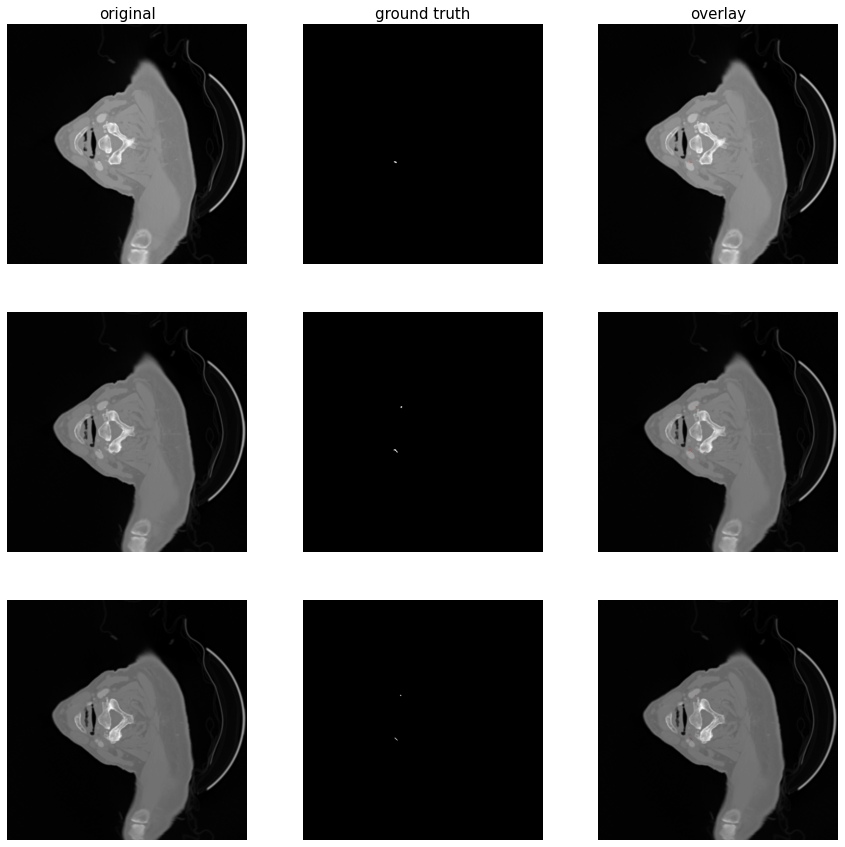

In [8]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [11]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


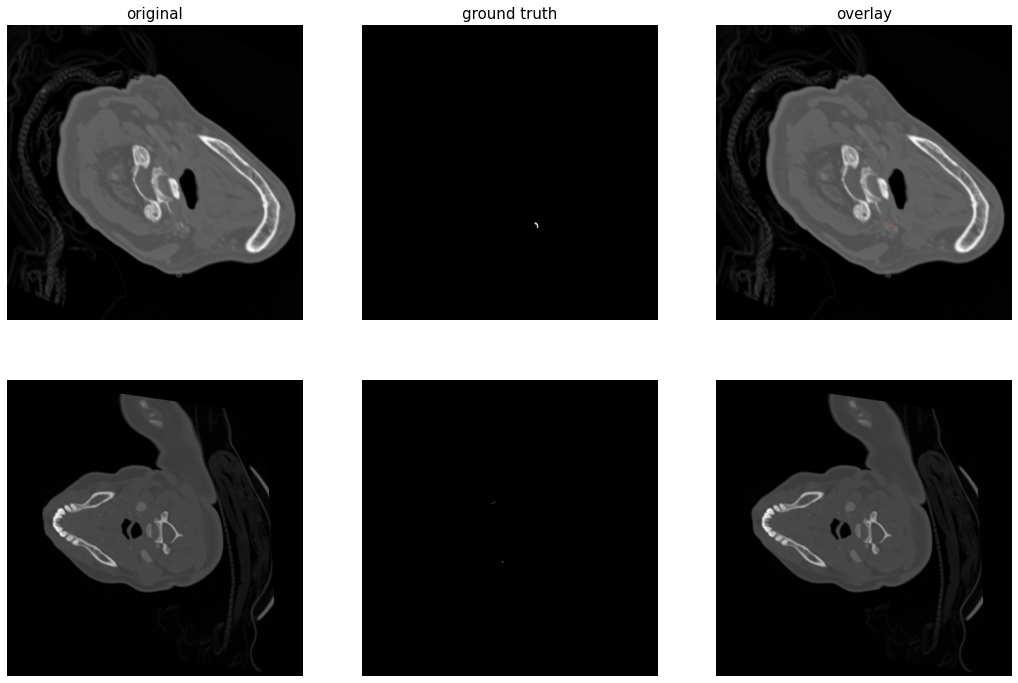

In [12]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=4, figsize=6)

In [13]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-04-13 16:59:37.049829: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-13 16:59:37.193259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-13 16:59:37.195892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-13 16:59:37.195911: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-13 16:59:37.195947: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-13 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-04-13 16:59:37.213335: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 16:59:37.431974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-13 16:59:37.434482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-13 16:59:37.444182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

In [14]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
history = model.fit(train_gen,
                    #X_train,
                    #y_train,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=200,
                    validation_data=(X_val, y_val))
                    #callbacks = [earlystopping])

2023-04-13 16:59:42.012261: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-13 16:59:42.033168: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-13 17:00:06.952251: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-13 17:00:07.760596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-13 17:00:07.760946: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-13 17:00:07.801541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-13 17:00:07.978180: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-04-13 17:00:08.457678: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-13 17:00:08.457700: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-13 17:00:08.45776

19/19 [==============================] - 39s 649ms/step - loss: 0.1161 - iou: 0.0060 - iou_thresholded: 0.0107 - val_loss: 0.0044 - val_iou: 5.2551e-04 - val_iou_thresholded: 6.0963e-04
Epoch 2/200
19/19 [==============================] - 7s 352ms/step - loss: 0.0042 - iou: 0.0096 - iou_thresholded: 0.0187 - val_loss: 0.0057 - val_iou: 6.0956e-04 - val_iou_thresholded: 6.0972e-04
Epoch 3/200
19/19 [==============================] - 7s 365ms/step - loss: 0.0050 - iou: 0.0086 - iou_thresholded: 0.0111 - val_loss: 0.0036 - val_iou: 5.8066e-04 - val_iou_thresholded: 5.7960e-04
Epoch 4/200
19/19 [==============================] - 6s 342ms/step - loss: 0.0025 - iou: 0.0084 - iou_thresholded: 0.0189 - val_loss: 0.0043 - val_iou: 0.0010 - val_iou_thresholded: 0.0012
Epoch 5/200
19/19 [==============================] - 7s 354ms/step - loss: 0.0042 - iou: 0.0164 - iou_thresholded: 0.0199 - val_loss: 0.0031 - val_iou: 5.2361e-04 - val_iou_thresholded: 6.0972e-04
Epoch 6/200
19/19 [===============

19/19 [==============================] - 7s 369ms/step - loss: 0.0015 - iou: 0.0073 - iou_thresholded: 0.0184 - val_loss: 0.0014 - val_iou: 0.0041 - val_iou_thresholded: 6.0972e-04
Epoch 44/200
19/19 [==============================] - 6s 348ms/step - loss: 0.0018 - iou: 0.0080 - iou_thresholded: 0.0176 - val_loss: 0.0017 - val_iou: 0.0015 - val_iou_thresholded: 6.0972e-04
Epoch 45/200
19/19 [==============================] - 6s 325ms/step - loss: 0.0020 - iou: 0.0087 - iou_thresholded: 0.0148 - val_loss: 0.0016 - val_iou: 0.0016 - val_iou_thresholded: 6.0972e-04
Epoch 46/200
19/19 [==============================] - 7s 366ms/step - loss: 0.0016 - iou: 0.0071 - iou_thresholded: 0.0220 - val_loss: 0.0015 - val_iou: 0.0022 - val_iou_thresholded: 6.0972e-04
Epoch 47/200
19/19 [==============================] - 6s 341ms/step - loss: 0.0012 - iou: 0.0079 - iou_thresholded: 0.0201 - val_loss: 0.0014 - val_iou: 0.0037 - val_iou_thresholded: 6.0972e-04
Epoch 48/200
19/19 [=======================

Epoch 86/200
19/19 [==============================] - 7s 361ms/step - loss: 0.0014 - iou: 0.0359 - iou_thresholded: 0.0266 - val_loss: 9.9259e-04 - val_iou: 0.0549 - val_iou_thresholded: 0.0418
Epoch 87/200
19/19 [==============================] - 7s 367ms/step - loss: 0.0012 - iou: 0.0362 - iou_thresholded: 0.0497 - val_loss: 0.0011 - val_iou: 0.0161 - val_iou_thresholded: 6.0972e-04
Epoch 88/200
19/19 [==============================] - 6s 328ms/step - loss: 0.0010 - iou: 0.0169 - iou_thresholded: 0.0223 - val_loss: 9.5528e-04 - val_iou: 0.0409 - val_iou_thresholded: 0.0141
Epoch 89/200
19/19 [==============================] - 7s 370ms/step - loss: 0.0011 - iou: 0.0390 - iou_thresholded: 0.0363 - val_loss: 0.0011 - val_iou: 0.0280 - val_iou_thresholded: 0.0052
Epoch 90/200
19/19 [==============================] - 7s 353ms/step - loss: 0.0013 - iou: 0.0310 - iou_thresholded: 0.0167 - val_loss: 9.8801e-04 - val_iou: 0.0620 - val_iou_thresholded: 0.0679
Epoch 91/200
19/19 [==============

19/19 [==============================] - 7s 357ms/step - loss: 9.5923e-04 - iou: 0.0420 - iou_thresholded: 0.0440 - val_loss: 8.4069e-04 - val_iou: 0.0643 - val_iou_thresholded: 0.0317
Epoch 129/200
19/19 [==============================] - 6s 327ms/step - loss: 7.6965e-04 - iou: 0.0483 - iou_thresholded: 0.0349 - val_loss: 8.2564e-04 - val_iou: 0.0766 - val_iou_thresholded: 0.0393
Epoch 130/200
19/19 [==============================] - 7s 355ms/step - loss: 7.3758e-04 - iou: 0.0591 - iou_thresholded: 0.0680 - val_loss: 9.2407e-04 - val_iou: 0.0595 - val_iou_thresholded: 0.0349
Epoch 131/200
19/19 [==============================] - 7s 356ms/step - loss: 8.1193e-04 - iou: 0.0609 - iou_thresholded: 0.0664 - val_loss: 8.9168e-04 - val_iou: 0.0667 - val_iou_thresholded: 0.0289
Epoch 132/200
19/19 [==============================] - 6s 334ms/step - loss: 8.6566e-04 - iou: 0.0474 - iou_thresholded: 0.0524 - val_loss: 0.0011 - val_iou: 0.0248 - val_iou_thresholded: 0.0013
Epoch 133/200
19/19 [==

Epoch 170/200
19/19 [==============================] - 7s 379ms/step - loss: 7.3148e-04 - iou: 0.0598 - iou_thresholded: 0.0698 - val_loss: 9.6618e-04 - val_iou: 0.0494 - val_iou_thresholded: 0.0202
Epoch 171/200
19/19 [==============================] - 7s 357ms/step - loss: 0.0014 - iou: 0.0476 - iou_thresholded: 0.0458 - val_loss: 8.1218e-04 - val_iou: 0.0752 - val_iou_thresholded: 0.0551
Epoch 172/200
19/19 [==============================] - 6s 325ms/step - loss: 8.9171e-04 - iou: 0.0505 - iou_thresholded: 0.0432 - val_loss: 8.8364e-04 - val_iou: 0.0930 - val_iou_thresholded: 0.1534
Epoch 173/200
19/19 [==============================] - 7s 366ms/step - loss: 0.0012 - iou: 0.0517 - iou_thresholded: 0.0613 - val_loss: 0.0010 - val_iou: 0.0524 - val_iou_thresholded: 0.0740
Epoch 174/200
19/19 [==============================] - 6s 338ms/step - loss: 0.0013 - iou: 0.0619 - iou_thresholded: 0.0688 - val_loss: 0.0016 - val_iou: 0.0059 - val_iou_thresholded: 6.0945e-04
Epoch 175/200
19/19 [

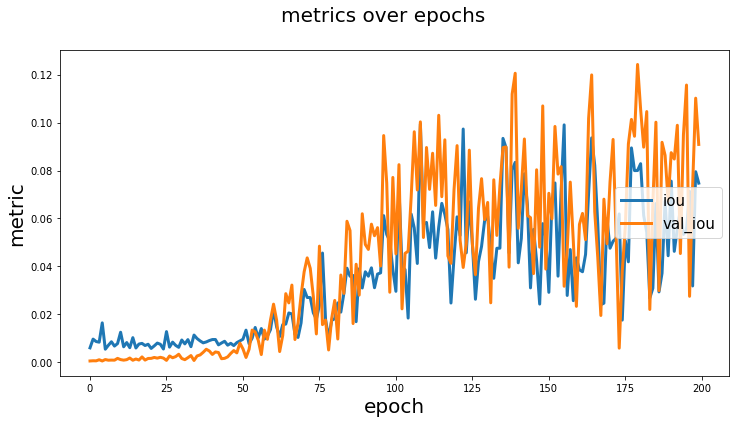

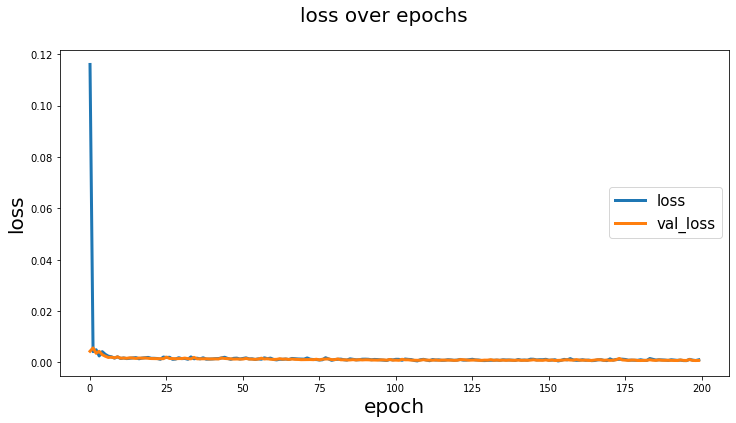

In [17]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [18]:
y_pred = model.predict(X_val)

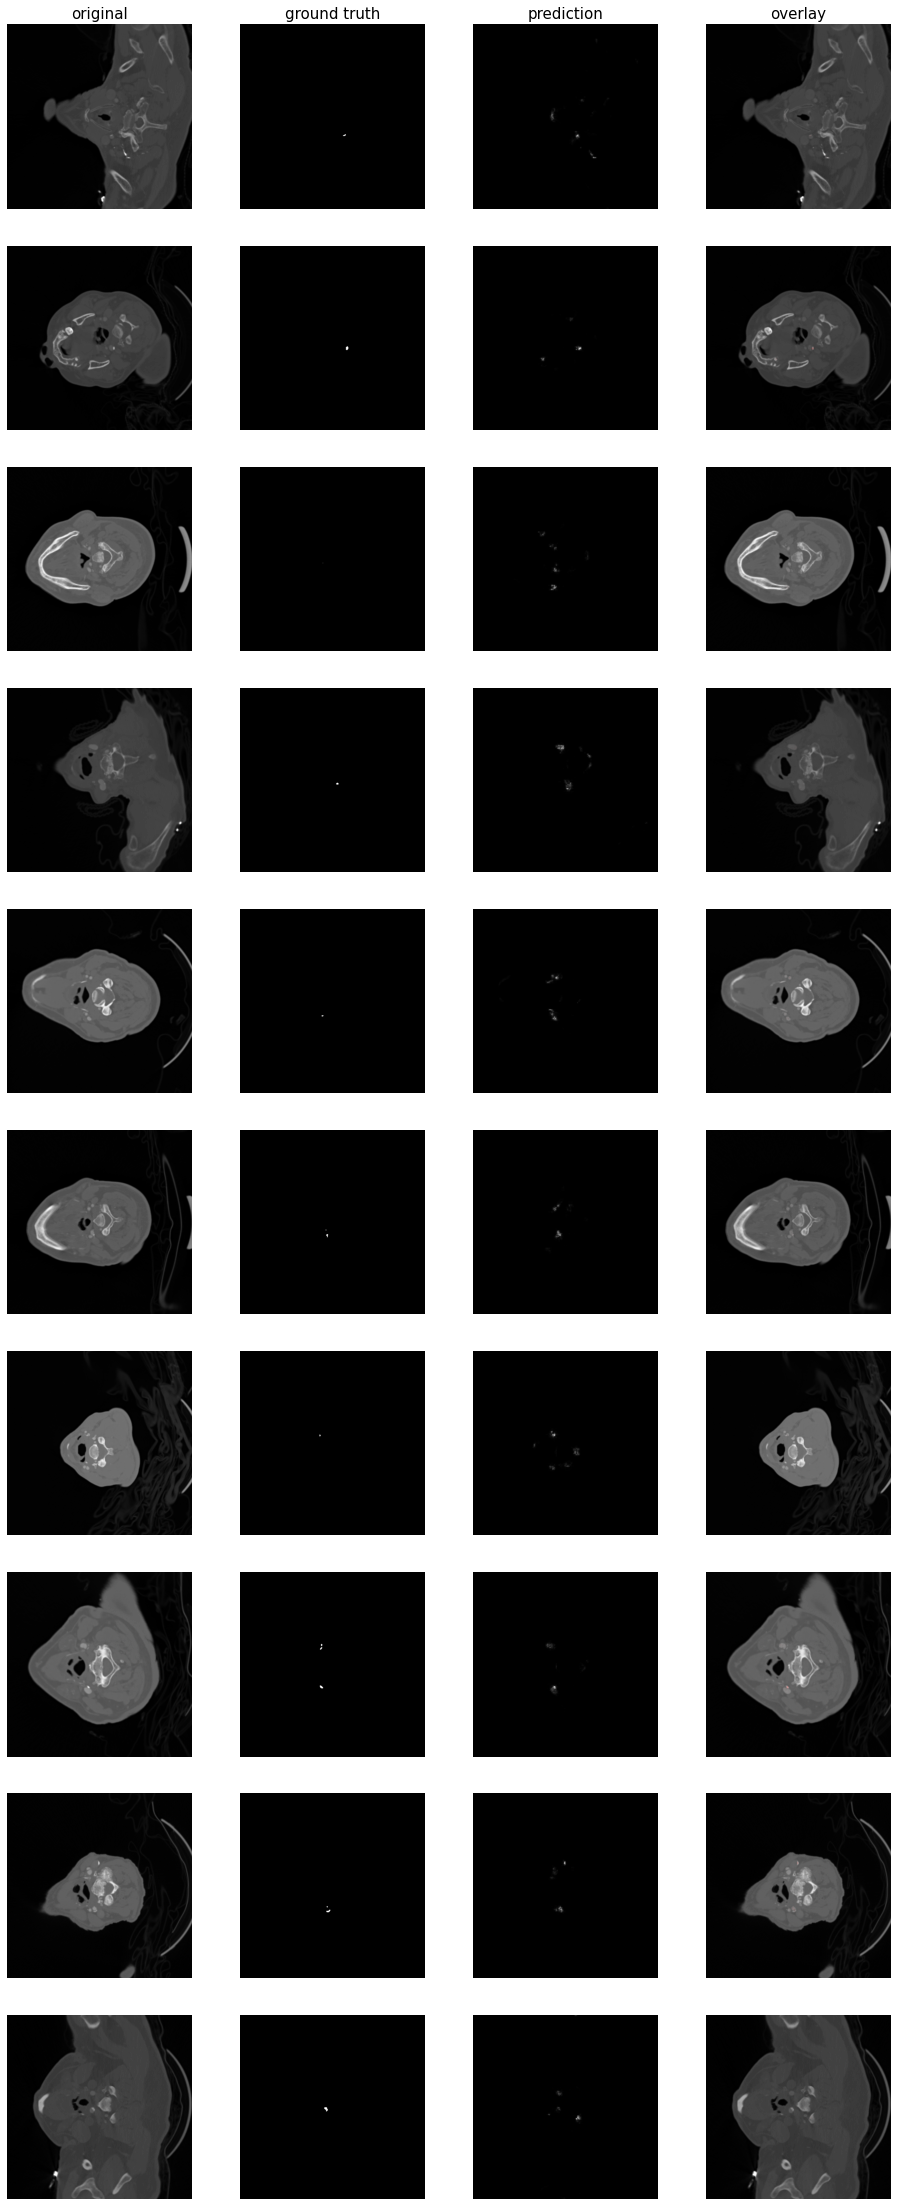

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [20]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 2s 471ms/step - loss: 7.9460e-04 - iou: 0.0909 - iou_thresholded: 0.1155
